# Fast tokenizers' special powers (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

<class 'transformers.tokenization_utils_base.BatchEncoding'>

In [ ]:
tokenizer.is_fast

True

In [ ]:
encoding.is_fast

True

In [ ]:
encoding.tokens()

['[CLS]', 'My', 'name', 'is', 'S', '##yl', '##va', '##in', 'and', 'I', 'work', 'at', 'Hu', '##gging', 'Face', 'in',
 'Brooklyn', '.', '[SEP]']

In [ ]:
encoding.word_ids()

[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]

In [ ]:
start, end = encoding.word_to_chars(3)
example[start:end]

Sylvain

# Inside the token-classification pipeline
In Chapter 1 we got our first taste of applying NER — where the task is to identify which parts of the text correspond to entities like persons, locations, or organizations — with the 🤗 Transformers `pipeline() `function.

Then, in Chapter 2, we saw how a pipeline groups together the three stages necessary to get the predictions from a raw text: `tokenization, passing the inputs through the model, and post-processing`.

The first two steps in the `token-classification pipeline` are the same as in any other pipeline, but the `post-processing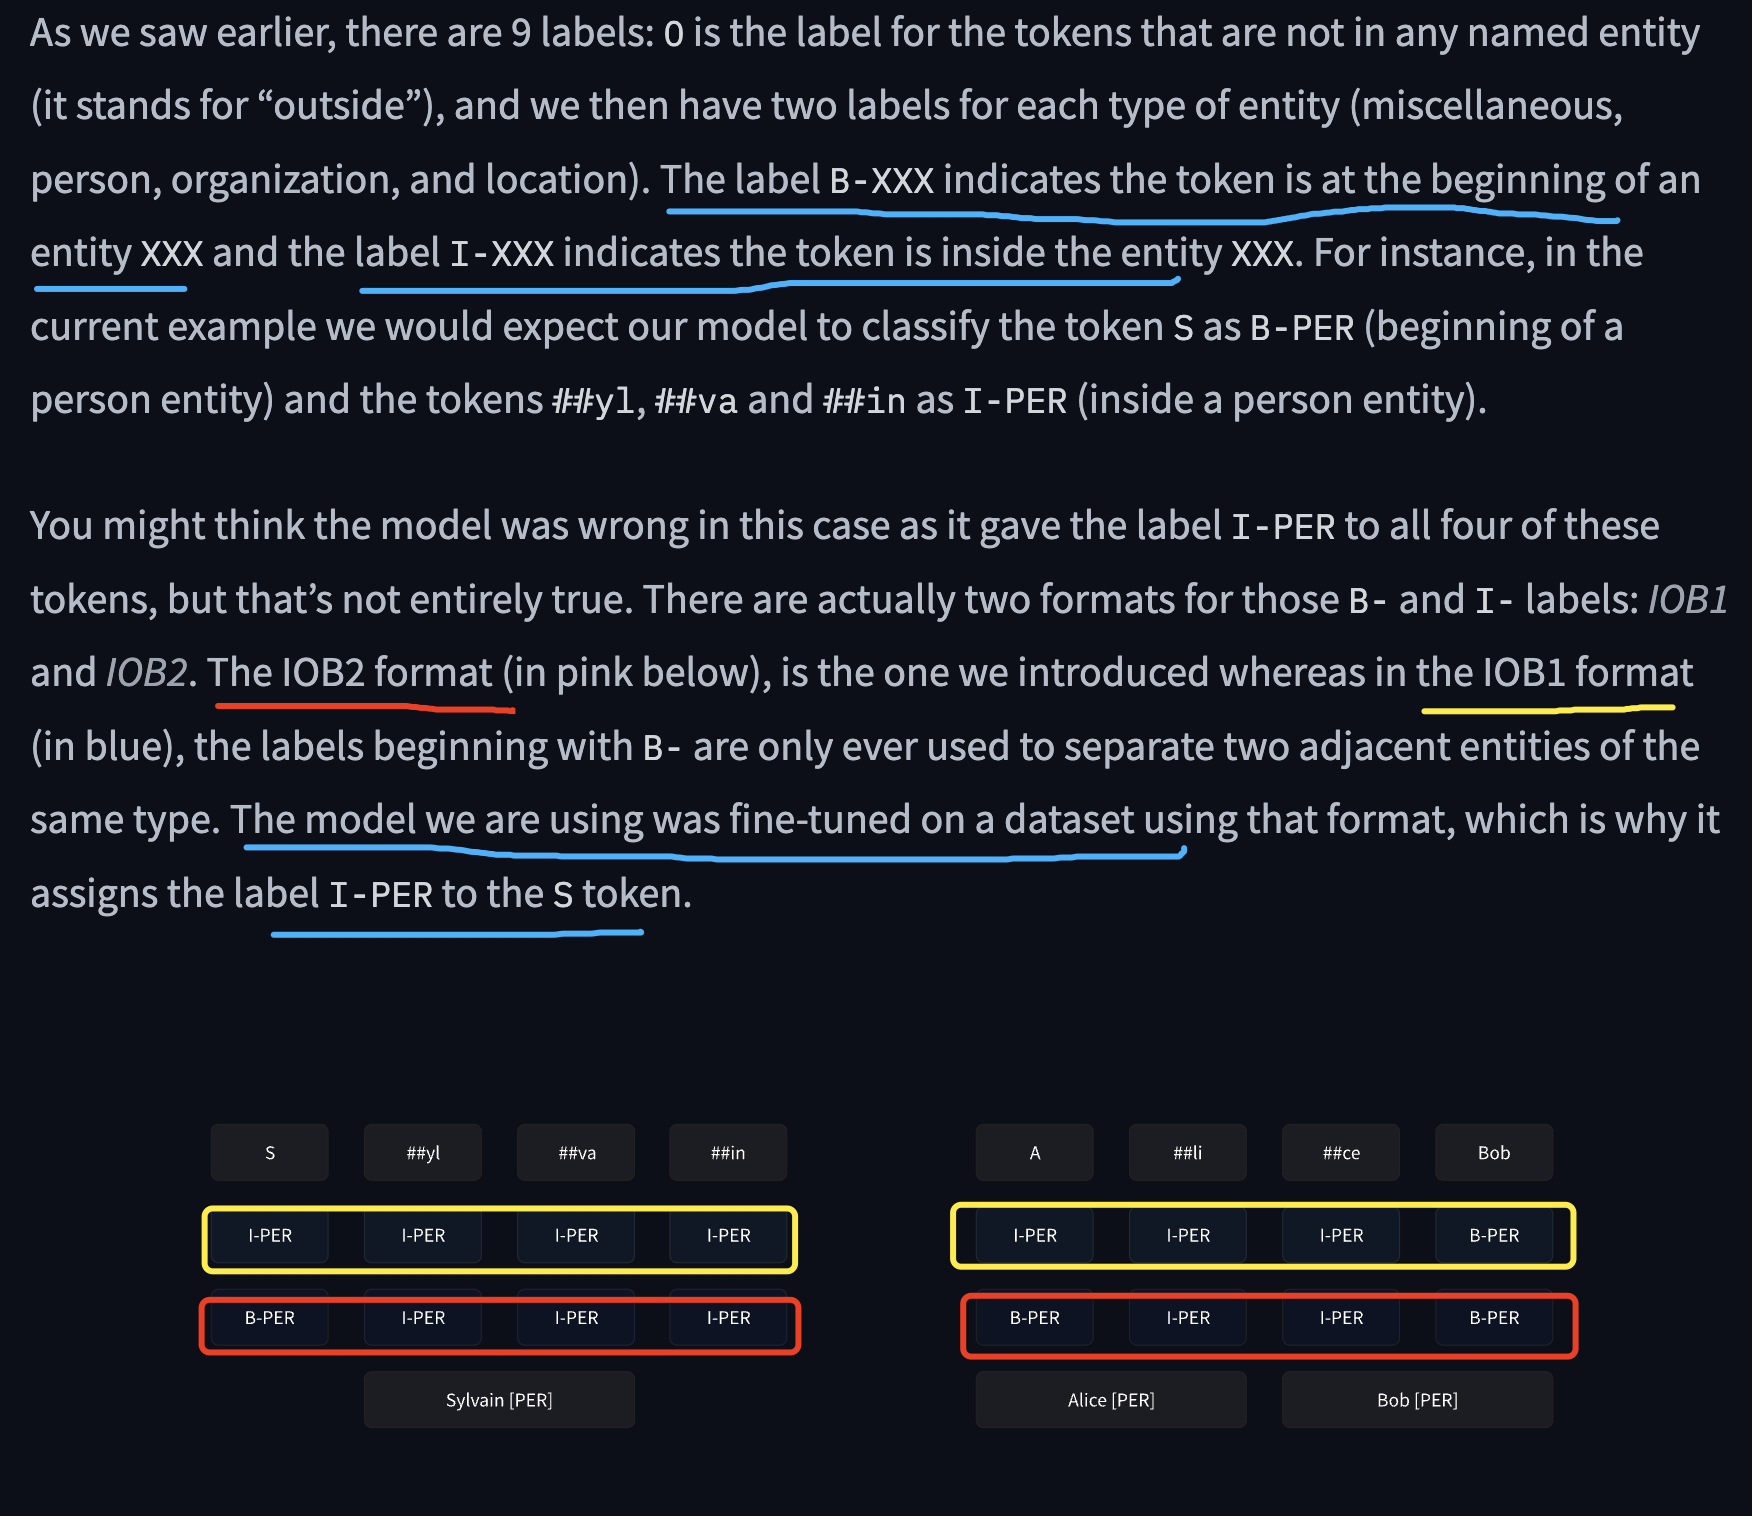` is a little more complex — let’s see how!

In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

[{'entity': 'I-PER', 'score': 0.9993828, 'index': 4, 'word': 'S', 'start': 11, 'end': 12},
 {'entity': 'I-PER', 'score': 0.99815476, 'index': 5, 'word': '##yl', 'start': 12, 'end': 14},
 {'entity': 'I-PER', 'score': 0.99590725, 'index': 6, 'word': '##va', 'start': 14, 'end': 16},
 {'entity': 'I-PER', 'score': 0.9992327, 'index': 7, 'word': '##in', 'start': 16, 'end': 18},
 {'entity': 'I-ORG', 'score': 0.97389334, 'index': 12, 'word': 'Hu', 'start': 33, 'end': 35},
 {'entity': 'I-ORG', 'score': 0.976115, 'index': 13, 'word': '##gging', 'start': 35, 'end': 40},
 {'entity': 'I-ORG', 'score': 0.98879766, 'index': 14, 'word': 'Face', 'start': 41, 'end': 45},
 {'entity': 'I-LOC', 'score': 0.99321055, 'index': 16, 'word': 'Brooklyn', 'start': 49, 'end': 57}]

The `aggregation_strategy` picked will change the scores computed for each grouped entity. With `"simple"` the score is just the `mean of the scores of each token in the given entity`: for instance, the score of “Sylvain” is the mean of the scores we saw in the previous example for the tokens S, ##yl, ##va, and ##in.

Other strategies available are:

- `"first"`, where the score of each entity is the score of the first token of that entity (so for “Sylvain” it would be 0.993828, the score of the token S)
- `"max"`, where the score of each entity is the maximum score of the tokens in that entity (so for “Hugging Face” it would be 0.98879766, the score of “Face”)
- `"average"`, where the score of each entity is the average of the scores of the words composing that entity (so for “Sylvain” there would be no difference from the "simple" strategy, but “Hugging Face” would have a score of 0.9819, the average of the scores for “Hugging”, 0.975, and “Face”, 0.98879)

In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

[{'entity_group': 'PER', 'score': 0.9981694, 'word': 'Sylvain', 'start': 11, 'end': 18},
 {'entity_group': 'ORG', 'score': 0.97960204, 'word': 'Hugging Face', 'start': 33, 'end': 45},
 {'entity_group': 'LOC', 'score': 0.99321055, 'word': 'Brooklyn', 'start': 49, 'end': 57}]

## From inputs to predictions
First we need to tokenize our input and pass it through the model. This is done exactly as in Chapter 2; we instantiate the tokenizer and the model using the `AutoXxx` classes and then use them on our example:


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

In [ ]:
print(inputs["input_ids"].shape)
print(outputs.logits.shape)

torch.Size([1, 19])
torch.Size([1, 19, 9])

We have a batch with 1 sequence of 19 tokens and the model has 9 different labels, so the output of the model has a shape of 1 x 19 x 9.


Like for the text classification pipeline, we use a softmax function to convert those logits to probabilities, and we take the argmax to get predictions (note that we can take the argmax on the logits because the softmax does not change the order):



In [ ]:
import torch

probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
print(predictions)

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]

The `model.config.id2label` attribute contains the mapping of indexes to labels that we can use to make sense of the predictions:

In [ ]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

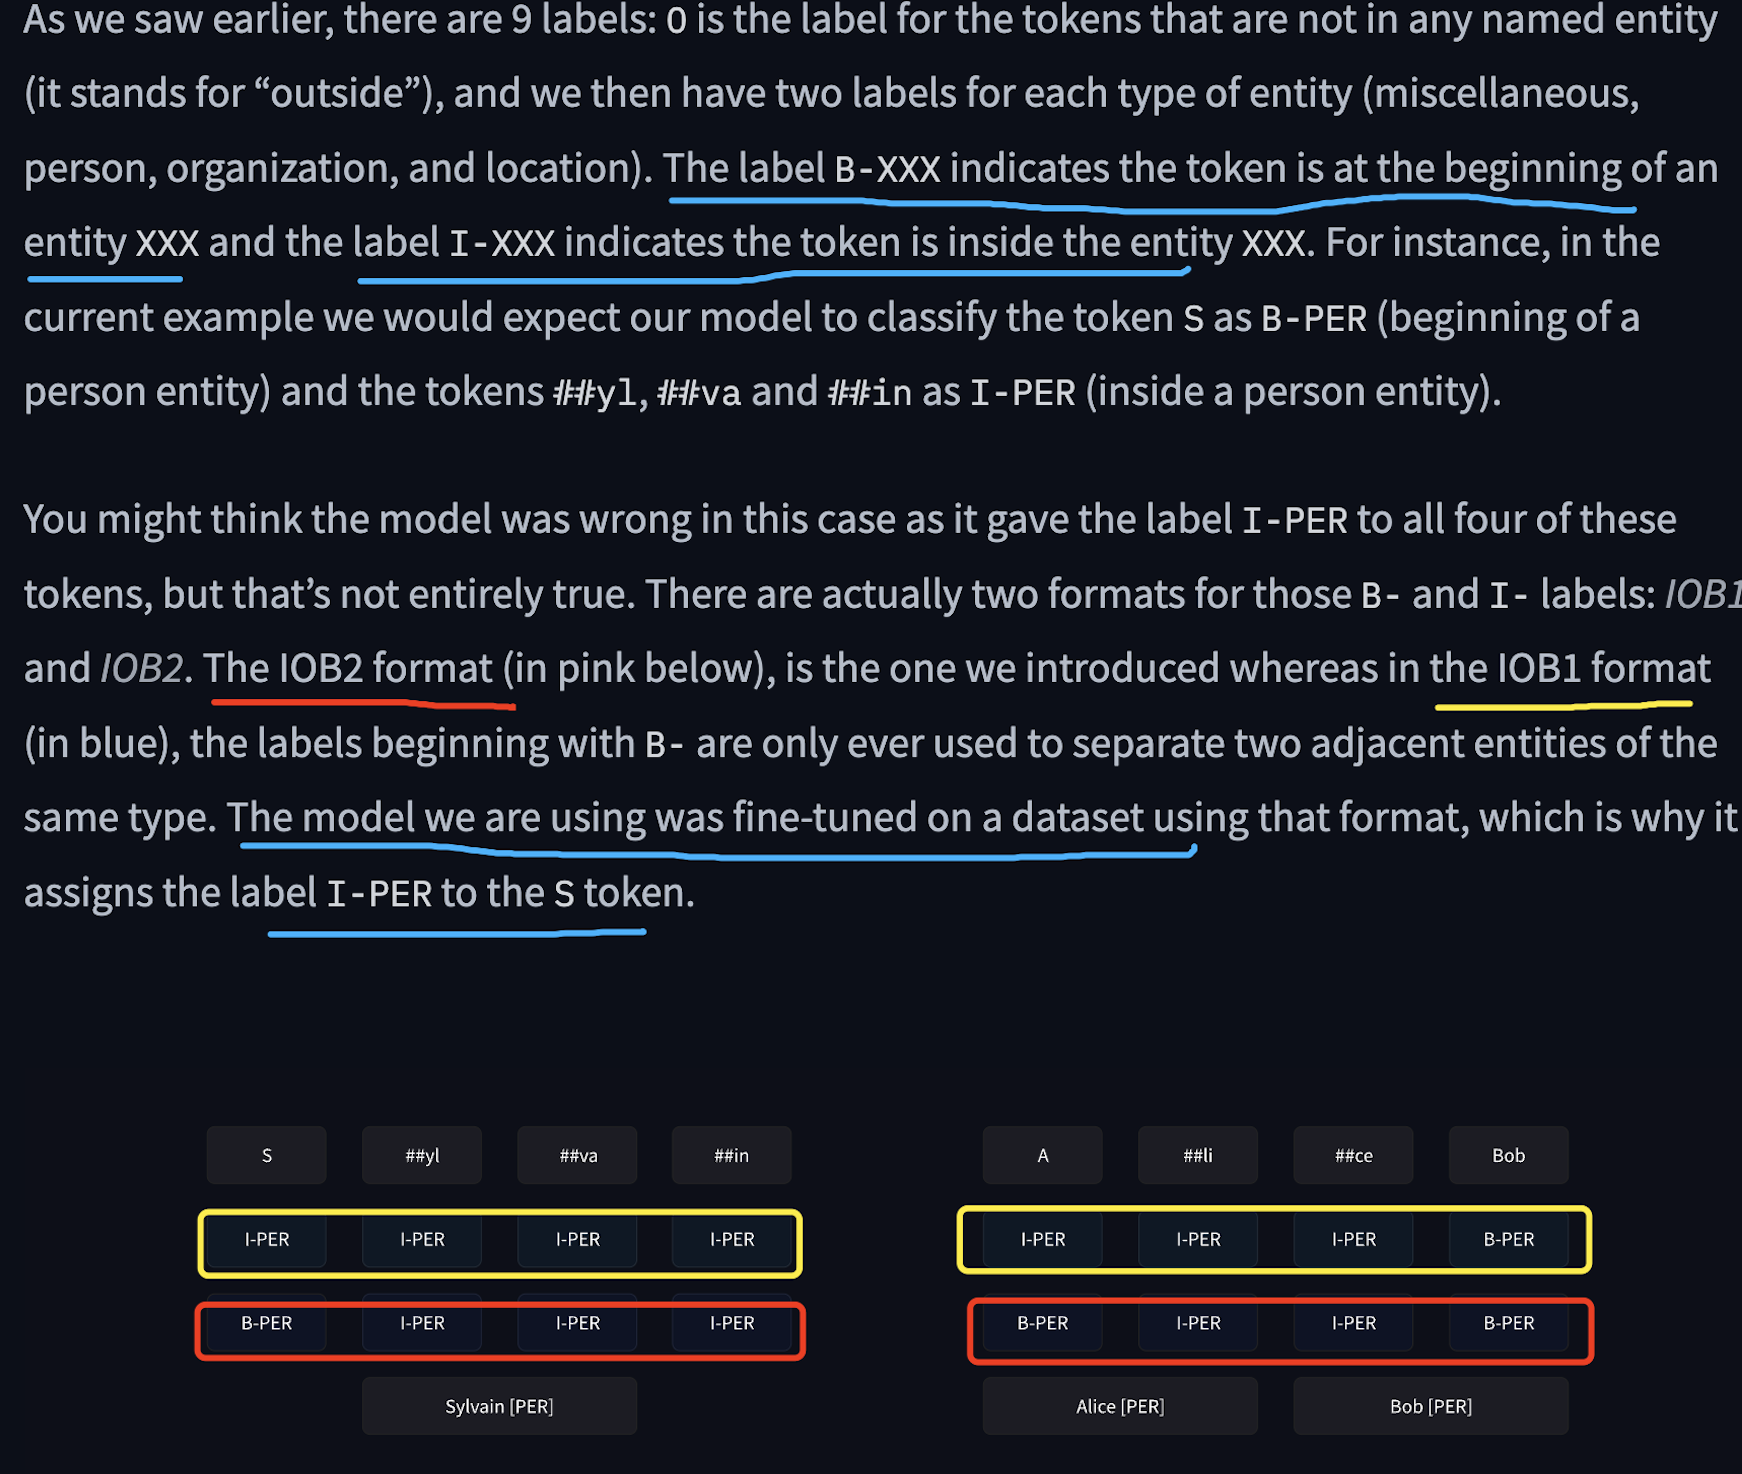

In [ ]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]}
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993828, 'index': 4, 'word': 'S'},
 {'entity': 'I-PER', 'score': 0.99815476, 'index': 5, 'word': '##yl'},
 {'entity': 'I-PER', 'score': 0.99590725, 'index': 6, 'word': '##va'},
 {'entity': 'I-PER', 'score': 0.9992327, 'index': 7, 'word': '##in'},
 {'entity': 'I-ORG', 'score': 0.97389334, 'index': 12, 'word': 'Hu'},
 {'entity': 'I-ORG', 'score': 0.976115, 'index': 13, 'word': '##gging'},
 {'entity': 'I-ORG', 'score': 0.98879766, 'index': 14, 'word': 'Face'},
 {'entity': 'I-LOC', 'score': 0.99321055, 'index': 16, 'word': 'Brooklyn'}]

This is very similar to what we had before, with one exception: the pipeline also gave us information `about the start and end of each entity` in the original sentence.

This is where our `offset mapping` will come into play. To get the offsets, we just have to set `return_offsets_mapping=True` when we apply the tokenizer to our inputs:

In [ ]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]

[(0, 0), (0, 2), (3, 7), (8, 10), (11, 12), (12, 14), (14, 16), (16, 18), (19, 22), (23, 24), (25, 29), (30, 32),
 (33, 35), (35, 40), (41, 45), (46, 48), (49, 57), (57, 58), (0, 0)]

In [ ]:
example[12:14]

yl

In [ ]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        start, end = offsets[idx]
        results.append(
            {
                "entity": label,
                "score": probabilities[idx][pred],
                "word": tokens[idx],
                "start": start,
                "end": end,
            }
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993828, 'index': 4, 'word': 'S', 'start': 11, 'end': 12},
 {'entity': 'I-PER', 'score': 0.99815476, 'index': 5, 'word': '##yl', 'start': 12, 'end': 14},
 {'entity': 'I-PER', 'score': 0.99590725, 'index': 6, 'word': '##va', 'start': 14, 'end': 16},
 {'entity': 'I-PER', 'score': 0.9992327, 'index': 7, 'word': '##in', 'start': 16, 'end': 18},
 {'entity': 'I-ORG', 'score': 0.97389334, 'index': 12, 'word': 'Hu', 'start': 33, 'end': 35},
 {'entity': 'I-ORG', 'score': 0.976115, 'index': 13, 'word': '##gging', 'start': 35, 'end': 40},
 {'entity': 'I-ORG', 'score': 0.98879766, 'index': 14, 'word': 'Face', 'start': 41, 'end': 45},
 {'entity': 'I-LOC', 'score': 0.99321055, 'index': 16, 'word': 'Brooklyn', 'start': 49, 'end': 57}]

# Grouping entities
- Using the offsets to determine the start and end keys for each entity is handy, but that information isn’t strictly necessary.

- When we want to group the entities together, however, the offsets will save us a lot of messy code. For example, if we wanted to group together the tokens Hu, ##gging, and Face, we could make special rules that say the first two should be attached while removing the ##, and the Face should be added with a space since it does not begin with ## — but that would only work for this particular type of tokenizer.

We would have to **write another set of rules** for a `SentencePiece` or a `Byte-Pair-Encoding tokenizer` (discussed later in this chapter).

With the offsets, all that custom code goes away: we just can take the span in the original text that begins with the first token and ends with the last token. So, in the case of the tokens Hu, ##gging, and Face, we should start at character 33 (the beginning of Hu) and end before character 45 (the end of Face):

In [ ]:
example[33:45]

Hugging Face

# Post-process

To write the code that post-processes the predictions while grouping entities, we will group together entities that are consecutive and labeled with I-XXX, except for the first one, which can be labeled as B-XXX or I-XXX (so, we stop grouping an entity when we get a O, a new type of entity, or a B-XXX that tells us an entity of the same type is starting):

In [ ]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):
    pred = predictions[idx]
    label = model.config.id2label[pred]
    if label != "O":
        # Remove the B- or I-
        label = label[2:]
        start, _ = offsets[idx]

        # Grab all the tokens labeled with I-label
        all_scores = []
        while (
            idx < len(predictions)
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):
            all_scores.append(probabilities[idx][pred])
            _, end = offsets[idx]
            idx += 1

        # The score is the mean of all the scores of the tokens in that grouped entity
        score = np.mean(all_scores).item()
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

print(results)

[{'entity_group': 'PER', 'score': 0.9981694, 'word': 'Sylvain', 'start': 11, 'end': 18},
 {'entity_group': 'ORG', 'score': 0.97960204, 'word': 'Hugging Face', 'start': 33, 'end': 45},
 {'entity_group': 'LOC', 'score': 0.99321055, 'word': 'Brooklyn', 'start': 49, 'end': 57}]

Another example of a task where these offsets are extremely useful is `question answering`. Diving into that pipeline, which we’ll do in the next section, will also enable us to take a look at one last feature of the tokenizers in the 🤗 Transformers library: dealing with overflowing tokens when we truncate an input to a given length.